# Exercise 5.12: Racetrack

<p style="text-align: justify;">
Consider driving a race car around a turn like those shown in the figures below. You want to go as fast as possible, but not so fast as to run off the track. In our simplified racetrack, the car is at one of a discrete set of grid positions, the cells in the diagram. The velocity is also discrete, a number of grid cells moved horizontally and vertically per time step. The actions are increments to the velocity components. Each may be changed by $+1$, $-1$, or $0$ in each step, for a total of nine $(3 \times 3)$ actions. Both velocity components are restricted to be nonnegative and less than $5$, and they cannot both be zero except at the starting line. Each episode begins in one of the randomly selected start states with both velocity components zero and ends when the car crosses the finish line. The rewards are $-1$ for each step until the car crosses the finish line. If the car hits the track boundary, it is moved back to a random position on the starting line, both velocity components are reduced to zero, and the episode continues. Before updating the car’s location at each time step, check to see if the projected path of the car intersects the track boundary. If it intersects the finish line, the episode ends; if it intersects anywhere else, the car is considered to have hit the track boundary and is sent back to the starting line. To make the task more challenging, with probability $0.1$ at each time step the velocity increments are both zero, independently of the intended increments. Apply a Monte Carlo control method to this task to compute the optimal policy from each starting state. Exhibit several trajectories following the optimal policy (but turn the noise off for these trajectories).
</p>

<hr style="height: 1px;">

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import time

from IPython.display import Image
from tqdm import tqdm

%matplotlib inline

### Helper functions

In [2]:
def create_path(mp, start_state, print_steps=False, print_outcome=True):
    
    # Load variables
    all_states  = mp['all_states']
    goal_states = mp['goal_states']
    P           = mp['P']

    # Initialize start state
    state = start_state

    if print_steps:
        print(f'Generating a path from state {state}...')

    # Initialize velocity
    velocity = (0, 0)

    # Initialize step counter        
    n_steps = 0

    while True:

        # If the car has reached one of the goal states
#             if state in goal_states:
#                 print(f'State: {state}')
#                 print(f'\nSUCCESS: Goal state {state} has been reached in {n_steps} steps!')
#                 break

        # Make an action by following the target policy
        action = P[state][velocity]

        if print_steps:
            print(f'{n_steps:>3} | State: {str(state):<8} | Velocity: {str(velocity):<8} | Action: {str(action):<8}')

        # Update velocity 
        velocity = get_next_velocity(velocity, action)

        # Move to the next state
        next_state = get_next_state(state, velocity)

        # Update step counter
        n_steps += 1

        # If the car has crossed the finish line
        if has_crossed_finish(next_state, goal_states):
            if print_steps:
                print(f'{n_steps:>3} | State: {next_state}')
            if print_outcome:
                print(f'\nSUCCESS: The car has crossed the finish line in {n_steps} steps!\n\n')
            return True

        # If the car gets out of bounds
        if next_state not in all_states:
            if print_steps:
                print(f'{n_steps:>3} | State: {next_state}')
            if print_outcome:
                print('\nFAILURE: The car got out of bounds by taking action ' + \
                     f'{action} on velocity {velocity} in state {state}!\n\n')
            return False

        # If the car has been caught in an infinite loop
        if state == next_state:
            if print_steps:
                print(f'{n_steps:>3} | State: {next_state}')
            if print_outcome:
                print(f'\nFAILURE: The car has got stuck in state {state}!\n\n')
            return False
        
        # Move to the next state
        state = next_state

    return

In [3]:
def generate_all_paths(mp):
    success = True
    for state in sorted(mp['start_states']):
        success &= create_path(mp, state, print_steps=True)
    return success

In [4]:
def dict_to_map(mp, dct):
    max_v, max_h = mp.shape
    return [
        [
            dct[(v, h)] if (v, h) in sorted(dct.keys()) else None
            for h in range(max_h)
        ]
        for v in range(max_v)
    ]

In [5]:
def generate_all_actions(vel_change):
    return {
        (v_change, h_change)
        for v_change in vel_change
        for h_change in vel_change
    }

In [6]:
def generate_all_states(mp):
    return {
        (v, h)
        for v in range(mp.shape[0])
        for h in range(mp.shape[1])
        if mp[v, h]
    }

In [7]:
def generate_all_velocities(max_speed):
    return {
        (v_vel, h_vel)
        for v_vel in range(-max_speed, max_speed+1)
        for h_vel in range(-max_speed, max_speed+1)
    }

In [8]:
def get_action_probs(pr_state):
    actions, probs = list(), list()
    
    for action in pr_state.keys():
        actions += [action]
        probs   += [pr_state[action]]
        
    return actions, probs

In [9]:
def get_best_action(q):
    best_value = -np.inf
    best_action = None
    
    for action in q.keys():
        if best_value < q[action]:
            best_value  = q[action]
            best_action = action
            
    return best_action

In [10]:
def get_next_state(state, velocity):
    return (state[0] + velocity[0],
            state[1] + velocity[1])

In [11]:
def get_next_velocity(velocity, action):
#     return (max(-max_speed, min(max_speed, velocity[0] + action[0])),
#             max(-max_speed, min(max_speed, velocity[1] + action[1])))
    return (velocity[0] + action[0],
            velocity[1] + action[1])

In [12]:
def has_crossed_finish(state, goal_states):
    for goal_state in goal_states:
        if state[0] == goal_state[0] and state[1] > goal_state[1]:
            return True

    return False

In [13]:
# def is_valid_trajectory(all_states, state, velocity):
#     new_states = {
#         (state[0] + velocity[0], state[1]),
#         (state[0]              , state[1] + velocity[1]),
#         (state[0] + velocity[0], state[1] + velocity[1])
#     }
#     return new_states.issubset(all_states)

In [14]:
def is_valid_action(velocity, action):
    if not -MAX_SPEED <= velocity[0] + action[0] <= MAX_SPEED \
    or not -MAX_SPEED <= velocity[1] + action[1] <= MAX_SPEED:
        return False
    return True

In [15]:
def plot_map(mp):
    plt.figure(figsize=(14, 14))
    sns.heatmap(np.flip(mp, axis=0), cbar=None, cmap='bwr',
                linewidths=0.05, square=True,
                yticklabels=np.arange(len(mp) - 1, -1, -1))
    plt.show()
    return

In [16]:
def print_policy(mp):
    for state in sorted(mp['all_states']):
        for velocity in sorted(mp['all_velocities']):
            print(state, velocity, mp['P'][state][velocity])
        print()
    return

In [17]:
def get_time():
    now = time.localtime()
    return f'{now.tm_year}-{now.tm_mon:02d}-{now.tm_mday:02d} ' \
           f'{now.tm_hour:02d}:{now.tm_min:02d}:{now.tm_sec:02d}'

### Settings

In [18]:
MAX_SPEED        = 4
POLICY_TYPES     = ['on', 'off_pred', 'off_control']
VELOCITY_CHANGE  = [-1, 0, 1]

### Constants

In [19]:
ALL_ACTIONS    = generate_all_actions(VELOCITY_CHANGE)
ALL_VELOCITIES = generate_all_velocities(MAX_SPEED)

VALID_ACTIONS = {
    velocity: {
        action
        for action in ALL_ACTIONS
        if is_valid_action(velocity, action)
    }
    for velocity in ALL_VELOCITIES
}

### Algorithms

#### Intialization

In [20]:
def initialize(mp, epsilon=1e-1):
    """
    mp: a given map
    """

    # Constants
    all_states = generate_all_states(mp)  # all valid states

    # Variables
    start_states = set()  # initial states (states at starting line)
    goal_states = set()  # final states (states at finish line)
    
    b = dict()   # behavior policy
    C = dict()   # cumulative sum of the weights to the returns
    P = dict()   # policy
    Q = dict()   # state-action values
    R = dict()   # rewards
    Pr = dict()  # probabilities of target policy

    for state in all_states:
        
        # States at starting line
        if state[0] == 0:
            start_states.add(state)
            
        # States at finish line
        if state[1] == mp.shape[1]-1:
            goal_states.add(state)
            
        b.setdefault(state, dict())
        C.setdefault(state, dict())
        Q.setdefault(state, dict())
        P.setdefault(state, dict())
        Pr.setdefault(state, dict())
        
        # Initialize rewards
        R[state] = -1
        
        for velocity in ALL_VELOCITIES:
            
            b[state].setdefault(velocity, dict())
            C[state].setdefault(velocity, dict())
            Q[state].setdefault(velocity, dict())
            P[state].setdefault(velocity, dict())
            Pr[state].setdefault(velocity, dict())
        
            for action in VALID_ACTIONS[velocity]:

                # Initialize behavior-policy probabilities
                b[state][velocity][action] = 1 / len(VALID_ACTIONS[velocity])

                # Initialize cumulative sums
                C[state][velocity][action] = 0.0  # state-action: cumulative sum

                # Initialize state-action values
                Q[state][velocity][action] = 0.0  # state-action: Q-value

                # Initialize probabilities
                Pr[state][velocity][action] = epsilon / len(VALID_ACTIONS[velocity])

            # Initialize policies randomly
#             best_action = random.choice(list(VALID_ACTIONS[velocity]))
            best_action = (0, 0)
            P[state][velocity] = best_action
            Pr[state][velocity][best_action] = (1 - epsilon) + (epsilon / len(VALID_ACTIONS[velocity]))
        
    return {
        'all_states': all_states,
        'start_states': start_states,
        'goal_states': goal_states,
        'b': b,
        'C': C,
        'P': P,
        'Q': Q,
        'R': R,
        'Pr': Pr,
        'total_episodes': 0,
    }

#### Iteration

In [21]:
def iterate(mp, policy_type,
            epsilon=1e-1, gamma=1.00, n_episodes=None, start_state=None,
            first_visit=True, same_start=False, unstable_only=False):
    """
    policy_type: {
        'on': On-policy Monte Carlo
        'off_pred': Off-policy MC prediction
        'off_control': Off-policy MC control
    }
    """

    if policy_type not in POLICY_TYPES:
        print('ERROR: Unknown policy type!')
        return mp

    # Load map
    all_states = mp['all_states']
    start_states = mp['start_states']
    goal_states = mp['goal_states']
    b = mp['b']
    C = mp['C']
    P = mp['P']
    Q = mp['Q']
    R = mp['R']
    Pr = mp['Pr']
    total_episodes = mp['total_episodes']
    
    n_iters = 0
    trained_states = set()
    unstable_states = start_states
    
#     print(f'{get_time()} | Iteration {total_episodes + n_iters:>9d} | Trained states: 0/{len(start_states)}')
    
    # Iterate
    while len(unstable_states) > 0:
        
        # Initialize velocity
        velocity = (0, 0)

        # Randomly select initial state, if no start state        
        if start_state is None:
            if unstable_only:
                start_state = random.choice(list(unstable_states))
            else:
                start_state = random.choice(list(start_states))
  
        state = start_state
        
        # Initialize step counter        
        n_steps = 1

        # Initialize actions and corresponding probabilities
        actions, probs = None, None
        
        # Initialize the flag of crossing the finish line
        crossed_finish_line = False
        
        # Initialize episode memory
        episode = []
        
        while not crossed_finish_line:
        
            # Randomly select next action
            # - On-policy Monte Carlo
            if policy_type == 'on':
                actions, probs = get_action_probs(Pr[state][velocity])
                
            # - Off-policy Monte Carlo
            if policy_type in {'off_pred', 'off_control'}:
                actions, probs = get_action_probs(b[state][velocity])

            action = np.random.choice(len(actions), p=probs)
            action = actions[action]

            # Making the task more challenging
#             if np.random.uniform() < 0.1:
#                 action = (0, 0)

            # Generate sequence of actions (1 episode)
            episode += [(state, velocity, action)]

            # Update velocity 
            velocity = get_next_velocity(velocity, action)

            # Move to the next state
            state = get_next_state(state, velocity)

            # Check whether the car is going to pass the finish line
            crossed_finish_line = has_crossed_finish(state, goal_states)
                
            # If the car gets out of bounds
            if state not in all_states and not crossed_finish_line:
                
                # Reduce velocity
                velocity = (0, 0)
                
                state = start_state
                
                # Randomly get back to initial state
                if not same_start:
                    if unstable_only:
                        state = random.choice(list(unstable_states))
                    else:
                        state = random.choice(list(start_states))
                
            # Increase counter of episode steps
            n_steps += 1

        # Increase counter of iterations/episodes
        n_iters += 1

        # Print last state of the episode
#         print(f'Episode {total_episodes + n_iters:>9d} | {n_steps:>9d} steps:', state, action, velocity)
        
        G = 0.0
        W = 1.0
        
        for t in range(len(episode)-1, -1, -1):
            state, velocity, action = episode[t]
            G = gamma * G + R[state]

            # If every-visit or (first-visit and the state was not encountered before)
            if not first_visit or (state, velocity, action) not in episode[:t]:
                
                # On-policy (first-visit) MC control (for epsilon-soft policies)
                if policy_type == 'on':
                    
                    # Incremental implementation
                    C[state][velocity][action] += 1.0
                    Q[state][velocity][action] += (G - Q[state][velocity][action]) / C[state][velocity][action]
            
                    best_action = get_best_action(Q[state][velocity])
                    n_actions = len(VALID_ACTIONS[velocity])

                    for action in Pr[state][velocity].keys():
                        Pr[state][velocity][action] = epsilon / n_actions

                    Pr[state][velocity][best_action] = (1 - epsilon) + (epsilon / n_actions)
                    P[state][velocity]               = best_action
                
                # Off-policy Monte Carlo
                if policy_type in {'off_pred', 'off_control'}:
                    C[state][velocity][action] += W
                    Q[state][velocity][action] += W / C[state][velocity][action] * (G - Q[state][velocity][action])

                    # Off-policy MC prediction (policy evaluation)
                    if policy_type == 'off_pred':
                        W *= Pr[state][velocity][action] / b[state][velocity][action]

                    # Off-policy Monte Carlo control
                    if policy_type == 'off_control':
                        P[state][velocity] = get_best_action(Q[state][velocity])
                        
                        if P[state][velocity] != action:
                            break
                        W /= b[state][velocity][action]
                    
        mp = {
            'all_states': all_states,
            'start_states': start_states,
            'goal_states': goal_states,
            'b': b,
            'C': C,
            'P': P,
            'Q': Q,
            'R': R,
            'Pr': Pr,
            'total_episodes': total_episodes + n_iters
        }
        
        # Get unstable states
        unstable_states_old = unstable_states
        unstable_states = set()
        for state in start_states:
            if not create_path(mp, state, print_outcome=False):
                unstable_states.add(state)
                    
        # Check whether there is a change in the set of unstable states
        if unstable_states != unstable_states_old:
            trained_states = start_states.difference(unstable_states)
#             print(f'\n{get_time()} | Iteration {total_episodes + n_iters:>9d} | Trained states: {len(trained_states)}/{len(start_states)}\n    {sorted(list(trained_states))}\n')
        
        if n_episodes is not None and n_iters == n_episodes:
            break
        
    print(f'The whole process has finished successfully after {total_episodes + n_iters} episodes!')
    
    return {
        'all_states': all_states,
        'start_states': start_states,
        'goal_states': goal_states,
        'b': b,
        'C': C,
        'P': P,
        'Q': Q,
        'R': R,
        'Pr': Pr,
        'total_episodes': total_episodes + n_iters
    }

<hr style="height: 1px;">

### Map 1

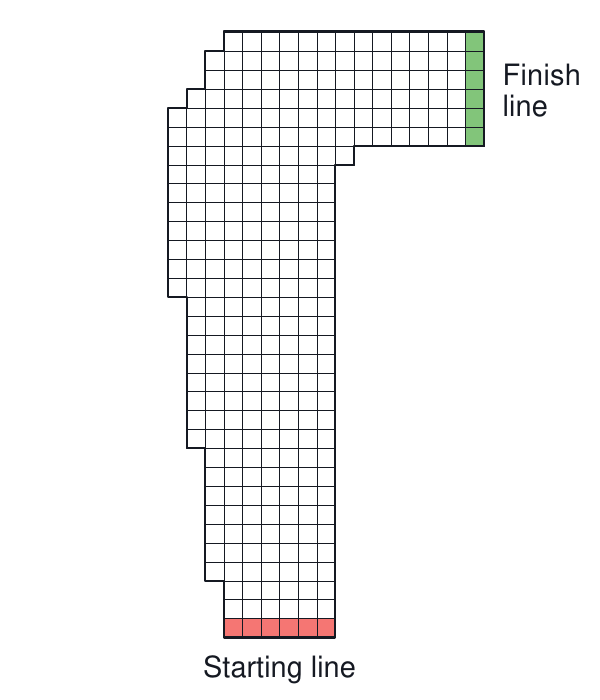

In [22]:
Image("ch05_ex12/map1.png")

In [23]:
m1 = np.zeros((32, 17), dtype=np.bool)

m1[31:32, 3:17] = True
m1[29:31, 2:17] = True
m1[28:29, 1:17] = True
m1[26:28, 0:17] = True
m1[25:26, 0:10] = True
m1[18:25, 0: 9] = True
m1[10:18, 1: 9] = True
m1[ 3:10, 2: 9] = True
m1[ 0: 3, 3: 9] = True

In [ ]:
plot_map(m1)

#### On-policy

In [24]:
m1_on = initialize(m1)

In [25]:
m1_on = iterate(m1_on, 'on', gamma=0.9999, n_episodes=10000000, first_visit=False, same_start=True)

The whole process has finished successfully after 133290205 episodes!


In [26]:
generate_all_paths(m1_on)

Generating a path from state (0, 3)...
  0 | State: (0, 3)   | Velocity: (0, 0)   | Action: (0, 1)  
  1 | State: (0, 4)   | Velocity: (0, 1)   | Action: (1, 1)  
  2 | State: (1, 6)   | Velocity: (1, 2)   | Action: (1, -1) 
  3 | State: (3, 7)   | Velocity: (2, 1)   | Action: (1, -1) 
  4 | State: (6, 7)   | Velocity: (3, 0)   | Action: (1, -1) 
  5 | State: (10, 6)  | Velocity: (4, -1)  | Action: (0, 0)  
  6 | State: (14, 5)  | Velocity: (4, -1)  | Action: (-1, 1) 
  7 | State: (17, 5)  | Velocity: (3, 0)   | Action: (1, 1)  
  8 | State: (21, 6)  | Velocity: (4, 1)   | Action: (-1, 1) 
  9 | State: (24, 8)  | Velocity: (3, 2)   | Action: (-1, 1) 
 10 | State: (26, 11) | Velocity: (2, 3)   | Action: (0, 1)  
 11 | State: (28, 15) | Velocity: (2, 4)   | Action: (0, 0)  
 12 | State: (30, 19)

SUCCESS: The car has crossed the finish line in 12 steps!


Generating a path from state (0, 4)...
  0 | State: (0, 4)   | Velocity: (0, 0)   | Action: (1, -1) 
  1 | State: (1, 3)   | Velocity:

True

#### Off-policy prediction

In [ ]:
# m1_off_pred = initialize(m1)

In [ ]:
# m1_off_pred = iterate(m1_off_pred, 'off_pred', same_start=True)

#### Off-policy control (State, Velocity $\rightarrow$ Action)

In [ ]:
# m1_off_control_sv = initialize(m1)

In [ ]:
# m1_off_control_sv = iterate(m1_off_control_sv, 'off_control', same_start=True)

In [ ]:
# generate_all_paths(m1_off_control_sv)

<hr style="height: 1px;">

### Map 2

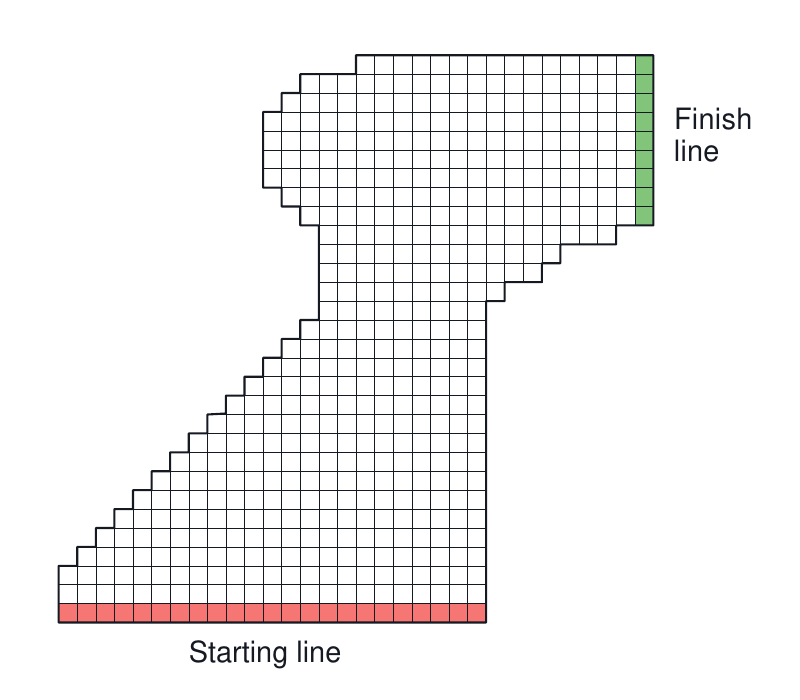

In [27]:
Image("ch05_ex12/map2.png")

In [28]:
m2 = np.zeros((30, 32), dtype=np.bool)

m2[29:30, 16:32] = True
m2[28:29, 13:32] = True
m2[27:28, 12:32] = True
m2[23:27, 11:32] = True
m2[22:23, 12:32] = True
m2[21:22, 13:32] = True
m2[20:21, 14:30] = True
m2[19:20, 14:27] = True
m2[18:19, 14:26] = True
m2[17:18, 14:24] = True
m2[16:17, 14:23] = True
m2[15:16, 13:23] = True
m2[14:15, 12:23] = True
m2[13:14, 11:23] = True
m2[12:13, 10:23] = True
m2[11:12,  9:23] = True
m2[10:11,  8:23] = True
m2[ 9:10,  7:23] = True
m2[ 8: 9,  6:23] = True
m2[ 7: 8,  5:23] = True
m2[ 6: 7,  4:23] = True
m2[ 5: 6,  3:23] = True
m2[ 4: 5,  2:23] = True
m2[ 3: 4,  1:23] = True
m2[ 0: 3,  0:23] = True

In [ ]:
plot_map(m2)

#### On-policy

In [29]:
m2_on = initialize(m2)

In [30]:
m2_on = iterate(m2_on, 'on', gamma=0.9999, n_episodes=10000000, first_visit=False, same_start=True)

The whole process has finished successfully after 840000012 episodes!


In [31]:
generate_all_paths(m2_on)

Generating a path from state (0, 0)...
  0 | State: (0, 0)   | Velocity: (0, 0)   | Action: (1, 1)  
  1 | State: (1, 1)   | Velocity: (1, 1)   | Action: (0, 1)  
  2 | State: (2, 3)   | Velocity: (1, 2)   | Action: (1, 1)  
  3 | State: (4, 6)   | Velocity: (2, 3)   | Action: (0, 1)  
  4 | State: (6, 10)  | Velocity: (2, 4)   | Action: (1, 0)  
  5 | State: (9, 14)  | Velocity: (3, 4)   | Action: (1, 0)  
  6 | State: (13, 18) | Velocity: (4, 4)   | Action: (0, 0)  
  7 | State: (17, 22) | Velocity: (4, 4)   | Action: (-1, 0) 
  8 | State: (20, 26) | Velocity: (3, 4)   | Action: (0, 0)  
  9 | State: (23, 30) | Velocity: (3, 4)   | Action: (0, 0)  
 10 | State: (26, 34)

SUCCESS: The car has crossed the finish line in 10 steps!


Generating a path from state (0, 1)...
  0 | State: (0, 1)   | Velocity: (0, 0)   | Action: (1, 1)  
  1 | State: (1, 2)   | Velocity: (1, 1)   | Action: (1, 1)  
  2 | State: (3, 4)   | Velocity: (2, 2)   | Action: (1, 1)  
  3 | State: (6, 7)   | Velocity:

True

#### Off-policy prediction

In [ ]:
# m2_off_pred = initialize(m2)

In [ ]:
# m2_off_pred = iterate(m2_off_pred, 'off_pred', same_start=True)

#### Off-policy control (State, Velocity $\rightarrow$ Action)

In [ ]:
# m2_off_control_sv = initialize(m2)

In [ ]:
# m2_off_control_sv = iterate(m2_off_control_sv, 'off_control', same_start=True)

In [ ]:
# generate_all_paths(m2_off_control_sv)